In [74]:
import os
from copy import deepcopy
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold

In [4]:
train = pd.read_csv("data/assignment_2_train.csv")
test = pd.read_csv("data/assignment_2_test.csv")
train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Задание 1:__ Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

Text(0.5, 0, 'TransactionDT')

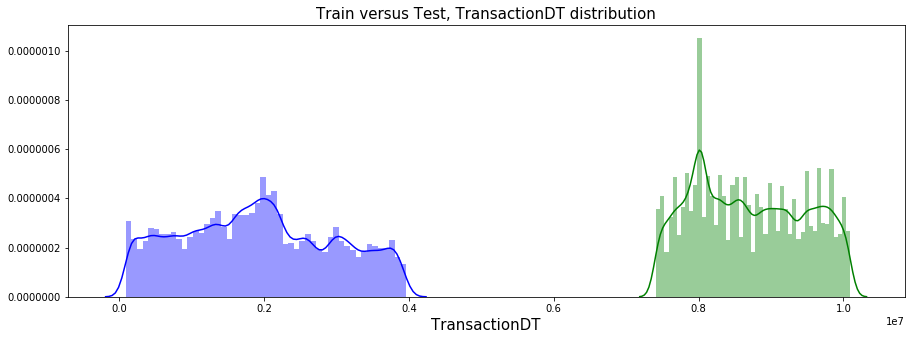

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.set_title("Train versus Test, TransactionDT distribution", fontsize=15)
sns.distplot(train["TransactionDT"], ax=axes, color="blue", label="train")
sns.distplot(test["TransactionDT"], ax=axes, color="green", label="test")
axes.set_xlabel("TransactionDT", fontsize=15)

Признак `TransactionDT` представляет собой разницу времени от заданного времени и времени совершения транзакции. Одним из первых инсайтов из данных может быть, что обучающая и тестовая выборка, по-видимому, разделены по времени. Между ними есть небольшой промежуток, но в целом, обучающая выборка относится к более раннему периоду времени, а тест - к более позднему периоду времени. Это может являться сигналом к тому, чтобы провести валидацию по времени. Мы рассмотрим это подробнее при рассмотрении различий в распределении признаков между обучением и тестом.

__Задание 2:__ построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

(0, 5000)

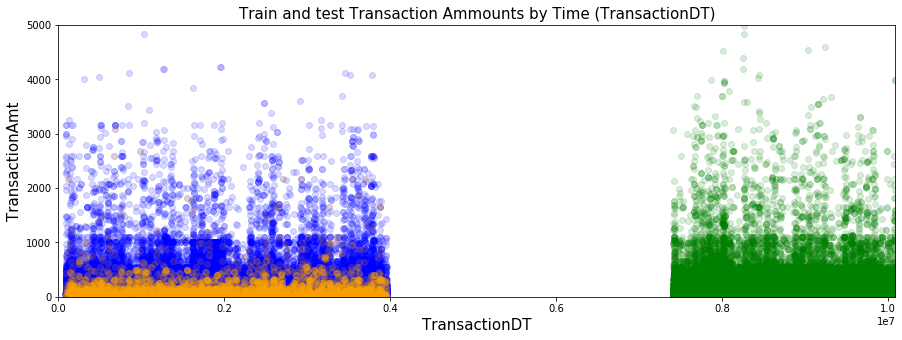

In [6]:
fig = plt.figure(figsize=(15, 5))
plt.title("Train and test Transaction Ammounts by Time (TransactionDT)", size=15)
plt.scatter(train["TransactionDT"], train["TransactionAmt"], alpha=0.15, color="blue")
plt.scatter(train.loc[train["isFraud"]==1, "TransactionDT"], train.loc[train["isFraud"]==1, "TransactionAmt"], alpha=0.15, color="orange")
plt.scatter(test["TransactionDT"], test["TransactionAmt"], alpha=0.15, color="green")
plt.xlim(0, test["TransactionDT"].max())
plt.ylabel("TransactionAmt", size=15)
plt.xlabel("TransactionDT", size=15)
plt.ylim(0, 5000)

Признак `TransactionAmt` интересно распределн в соответствии с `TransactionDT`. В основном, большая часть мошеннических операций сосредоточена на маленьких суммах, что является не удивительным. Кажется, что мошенничество на маленькие суммы оправдано, поскольку клиенты могут этого не заметить / не захотеть обращаться в банк для претензионной работы. При этом, мошеннические операции имеют явную периодичность: возможно, мошенничество совершается, по большей часте, по будням.

__Задание 3:__ построить распределение признака `TransactionAmt` в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

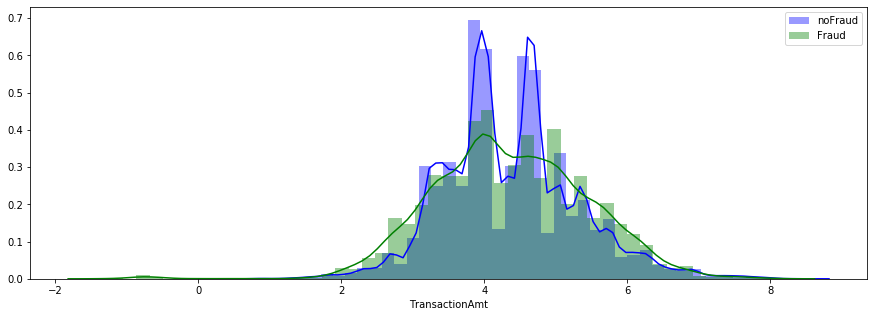

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.distplot(np.log(train.loc[train["isFraud"]==0, "TransactionAmt"]), color="Blue", label="noFraud")
sns.distplot(np.log(train.loc[train["isFraud"]==1, "TransactionAmt"]), color="Green", label="Fraud")
plt.legend()

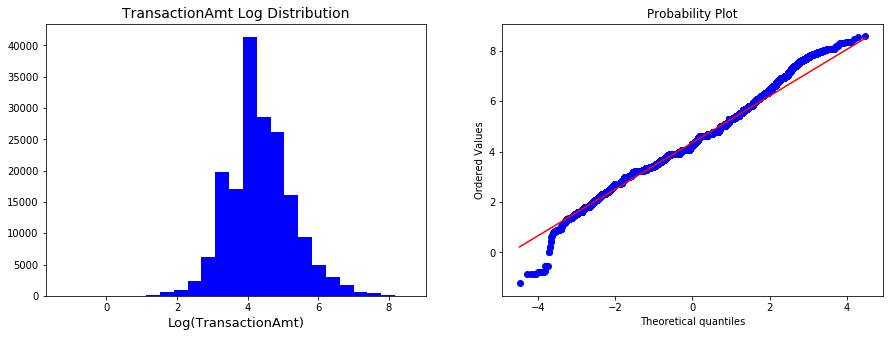

In [8]:
transaction_amt_log = np.log(train["TransactionAmt"])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title("TransactionAmt Log Distribution", fontsize=14)
axes[0].set_xlabel("Log(TransactionAmt)", fontsize=13)
axes[0].hist(transaction_amt_log, bins=25, color="blue")
probplot(transaction_amt_log, plot=axes[1])
plt.show()

Будем использовать логарифмическое преобразование признаков, чтобы лучше проанализировать распределение признака `TransactionAmt`, поскольку распределение исходного признака сильно скошено. Распределение `TransactionAmt` в разрезе целевой переменной демонстрирует явное отличие распределений. Распределение объектов фонового класса является более узким, более кучно сосредоточены вокруг среднего значения логарифмированного признака. Распределение логарифмированной переменной не является нормальным, QQ-график выглядит сильно отличным от графика нормального распределения.

__Задание 4:__ построить распределение признака целевой переменной в зависимости от значений категориальных признаков `ProductCD`, `card4`, `card6`. Сделать выводы.

Признак `ProductCD`:
* достоверно неизвестно, что означает данный признак, мы можем только предполагать
* Значение `W` - наиболее распространенное, значение `S` - наименее распространенное
* `ProductCD` равный `C` имеет наибольший уровень мошенничества (практически 10%)
* `ProductCD` равный `H` имеет меньше 2% уровня мошенничества


Text(0, 0.5, 'count')

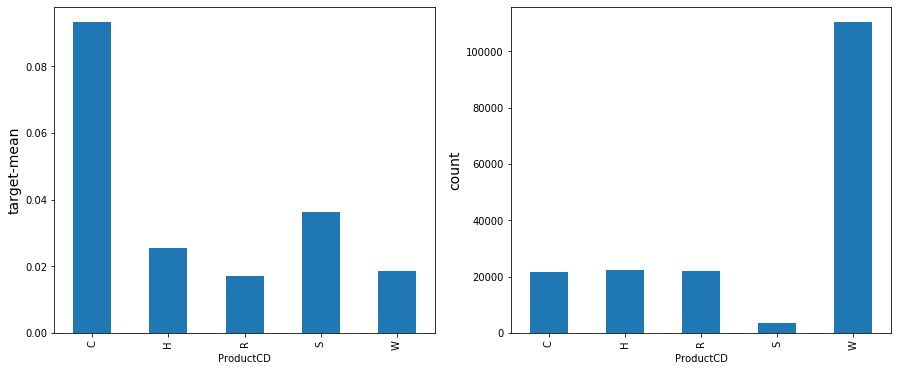

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train.groupby(["ProductCD"])["isFraud"].mean().plot(kind="bar", ax=axes[0])
train.groupby(["ProductCD"])["isFraud"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

Text(0, 0.5, 'count')

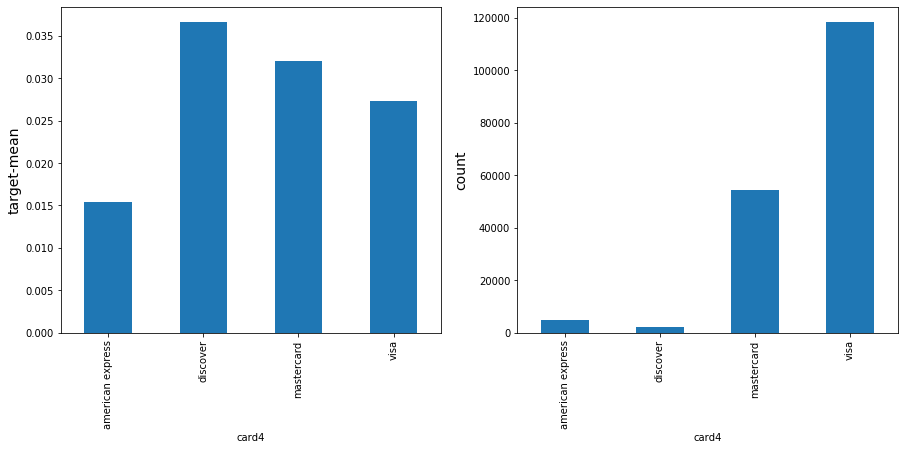

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train.groupby(["card4"])["isFraud"].mean().plot(kind="bar", ax=axes[0])
train.groupby(["card4"])["isFraud"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

Text(0, 0.5, 'count')

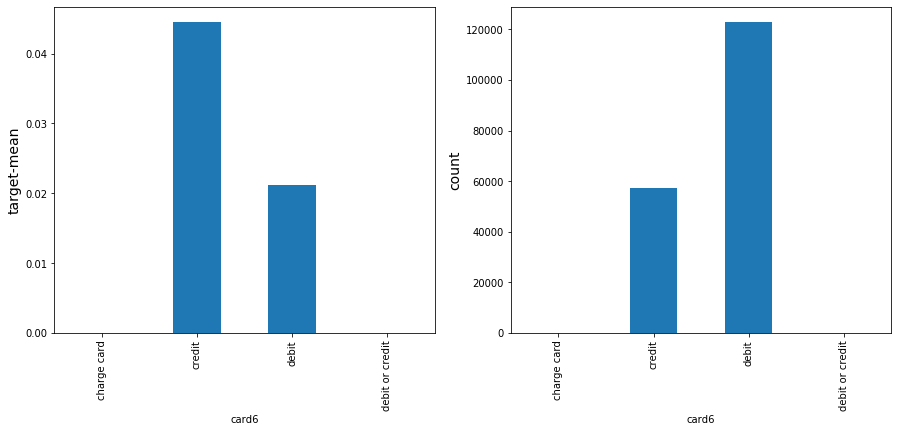

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train.groupby(["card6"])["isFraud"].mean().plot(kind="bar", ax=axes[0])
train.groupby(["card6"])["isFraud"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

## Основное задание

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче.


##  Hold-Out валидация на 2 выборки

__Задание 1:__ сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (`TransactionID`), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [14]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = cb.CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model

def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

def prepare_data(X, categorical, to_drop):
    """
    Преобразование данных для передачи в модель.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для передачи в модель.

    categorical: List[str]
        Список с названием категориальных признаков.

    drop_features: List[str]
        Список с названием признаков, которые не должны
        участвовать в обучении.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Матрица признаков, подготовленная для передачи в модель.

    """
    X_transformed = X.copy()
    to_drop = set(X.columns) & set(to_drop)

    if to_drop:
        X_transformed = X_transformed.drop(to_drop, axis=1)

    X_transformed[categorical] = X_transformed[categorical].astype(str)
    return X_transformed

In [15]:
to_drop = [
    "TransactionID",
    "TransactionDT",
    "isFraud",
]

categorical = train.select_dtypes(include=["object"]).columns.tolist()

In [16]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

In [17]:
x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_public_lb.shape))

x_train.shape = 125999 rows, 391 cols
x_valid.shape = 54001 rows, 391 cols
x_test.shape = 100001 rows, 391 cols


In [18]:
cb_params_1000 = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.6186335	best: 0.6186335 (0)	total: 239ms	remaining: 3m 58s
10:	test: 0.7947296	best: 0.7947296 (10)	total: 1.83s	remaining: 2m 44s
20:	test: 0.7937902	best: 0.7949854 (11)	total: 3.43s	remaining: 2m 40s
30:	test: 0.7934548	best: 0.7957345 (23)	total: 5.04s	remaining: 2m 37s
40:	test: 0.8215943	best: 0.8215943 (40)	total: 6.68s	remaining: 2m 36s
50:	test: 0.8245923	best: 0.8256124 (48)	total: 8.46s	remaining: 2m 37s
60:	test: 0.8366680	best: 0.8366680 (60)	total: 10.4s	remaining: 2m 39s
70:	test: 0.8405628	best: 0.8405628 (70)	total: 12.6s	remaining: 2m 44s
80:	test: 0.8436723	best: 0.8436723 (80)	total: 14.6s	remaining: 2m 45s
90:	test: 0.8467741	best: 0.8469130 (89)	total: 16.3s	remaining: 2m 43s
100:	test: 0.8500312	best: 0.8500312 (100)	total: 18s	remaining: 2m 40s
110:	test: 0.8514908	best: 0.8514908 (110)	total: 19.6s	remaining: 2m 37s
120:	test: 0.8532262	best: 0.8532381 (118)	total: 21.3s	remaining: 2m 34s
130:	test: 0.8543193	best: 0.8543193 (130)	total: 23s	remainin

In [19]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

score = 0.891472
score = 0.879177
score = 0.862748


In [23]:
cb_params_10000 = {
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

model = fit_catboost(
    x_train, y_train, cb_params_10000, categorical, x_valid, y_valid)

0:	test: 0.6186335	best: 0.6186335 (0)	total: 174ms	remaining: 28m 59s
10:	test: 0.7947296	best: 0.7947296 (10)	total: 1.83s	remaining: 27m 39s
20:	test: 0.7937902	best: 0.7949854 (11)	total: 3.46s	remaining: 27m 22s
30:	test: 0.7934548	best: 0.7957345 (23)	total: 5.08s	remaining: 27m 12s
40:	test: 0.8215943	best: 0.8215943 (40)	total: 6.92s	remaining: 28m 1s
50:	test: 0.8245923	best: 0.8256124 (48)	total: 8.76s	remaining: 28m 28s
60:	test: 0.8366680	best: 0.8366680 (60)	total: 10.6s	remaining: 28m 39s
70:	test: 0.8405628	best: 0.8405628 (70)	total: 12.4s	remaining: 28m 55s
80:	test: 0.8436723	best: 0.8436723 (80)	total: 14.6s	remaining: 29m 49s
90:	test: 0.8467741	best: 0.8469130 (89)	total: 16.3s	remaining: 29m 37s
100:	test: 0.8500312	best: 0.8500312 (100)	total: 18s	remaining: 29m 25s
110:	test: 0.8514908	best: 0.8514908 (110)	total: 19.6s	remaining: 29m 8s
120:	test: 0.8532262	best: 0.8532381 (118)	total: 21.4s	remaining: 29m 9s
130:	test: 0.8543193	best: 0.8543193 (130)	total: 23

1100:	test: 0.8925390	best: 0.8925390 (1100)	total: 3m 38s	remaining: 29m 26s
1110:	test: 0.8928085	best: 0.8928085 (1110)	total: 3m 40s	remaining: 29m 24s
1120:	test: 0.8929935	best: 0.8929935 (1120)	total: 3m 42s	remaining: 29m 21s
1130:	test: 0.8930885	best: 0.8930888 (1129)	total: 3m 44s	remaining: 29m 19s
1140:	test: 0.8931417	best: 0.8931417 (1140)	total: 3m 46s	remaining: 29m 15s
1150:	test: 0.8932096	best: 0.8932096 (1150)	total: 3m 48s	remaining: 29m 13s
1160:	test: 0.8932585	best: 0.8932585 (1160)	total: 3m 49s	remaining: 29m 10s
1170:	test: 0.8932783	best: 0.8932783 (1170)	total: 3m 51s	remaining: 29m 8s
1180:	test: 0.8933524	best: 0.8933524 (1180)	total: 3m 53s	remaining: 29m 5s
1190:	test: 0.8934323	best: 0.8934323 (1190)	total: 3m 55s	remaining: 29m 2s
1200:	test: 0.8934923	best: 0.8934929 (1199)	total: 3m 57s	remaining: 28m 58s
1210:	test: 0.8935262	best: 0.8935262 (1210)	total: 3m 59s	remaining: 28m 57s
1220:	test: 0.8935333	best: 0.8935333 (1220)	total: 4m 1s	remaining

2160:	test: 0.8988050	best: 0.8988050 (2160)	total: 6m 53s	remaining: 24m 58s
2170:	test: 0.8988131	best: 0.8988131 (2170)	total: 6m 54s	remaining: 24m 55s
2180:	test: 0.8988216	best: 0.8988216 (2180)	total: 6m 56s	remaining: 24m 52s
2190:	test: 0.8988627	best: 0.8988628 (2189)	total: 6m 58s	remaining: 24m 50s
2200:	test: 0.8988829	best: 0.8988830 (2199)	total: 6m 59s	remaining: 24m 48s
2210:	test: 0.8988933	best: 0.8988933 (2209)	total: 7m 1s	remaining: 24m 46s
2220:	test: 0.8991270	best: 0.8991270 (2220)	total: 7m 3s	remaining: 24m 44s
2230:	test: 0.8991539	best: 0.8991539 (2225)	total: 7m 5s	remaining: 24m 42s
2240:	test: 0.8991703	best: 0.8991703 (2240)	total: 7m 7s	remaining: 24m 41s
2250:	test: 0.8991717	best: 0.8991718 (2247)	total: 7m 9s	remaining: 24m 38s
2260:	test: 0.8992186	best: 0.8992186 (2260)	total: 7m 11s	remaining: 24m 37s
2270:	test: 0.8992264	best: 0.8992266 (2262)	total: 7m 13s	remaining: 24m 34s
2280:	test: 0.8992409	best: 0.8992410 (2277)	total: 7m 15s	remaining:

3220:	test: 0.9019556	best: 0.9019556 (3220)	total: 10m 16s	remaining: 21m 38s
3230:	test: 0.9020502	best: 0.9020502 (3230)	total: 10m 19s	remaining: 21m 37s
3240:	test: 0.9020969	best: 0.9020971 (3239)	total: 10m 20s	remaining: 21m 34s
3250:	test: 0.9021423	best: 0.9021423 (3250)	total: 10m 22s	remaining: 21m 32s
3260:	test: 0.9022371	best: 0.9022371 (3260)	total: 10m 24s	remaining: 21m 30s
3270:	test: 0.9022659	best: 0.9022659 (3270)	total: 10m 26s	remaining: 21m 27s
3280:	test: 0.9023633	best: 0.9023633 (3280)	total: 10m 27s	remaining: 21m 25s
3290:	test: 0.9024700	best: 0.9024700 (3290)	total: 10m 29s	remaining: 21m 23s
3300:	test: 0.9025584	best: 0.9025584 (3300)	total: 10m 31s	remaining: 21m 22s
3310:	test: 0.9026608	best: 0.9026608 (3310)	total: 10m 33s	remaining: 21m 20s
3320:	test: 0.9026947	best: 0.9026947 (3320)	total: 10m 35s	remaining: 21m 18s
3330:	test: 0.9028591	best: 0.9028591 (3330)	total: 10m 37s	remaining: 21m 16s
3340:	test: 0.9029037	best: 0.9029037 (3340)	total: 

4270:	test: 0.9062651	best: 0.9062651 (4270)	total: 13m 42s	remaining: 18m 23s
4280:	test: 0.9062872	best: 0.9062872 (4280)	total: 13m 44s	remaining: 18m 20s
4290:	test: 0.9063981	best: 0.9063981 (4290)	total: 13m 45s	remaining: 18m 18s
4300:	test: 0.9064345	best: 0.9064345 (4300)	total: 13m 47s	remaining: 18m 16s
4310:	test: 0.9064562	best: 0.9064562 (4310)	total: 13m 49s	remaining: 18m 14s
4320:	test: 0.9064839	best: 0.9064839 (4320)	total: 13m 50s	remaining: 18m 11s
4330:	test: 0.9065100	best: 0.9065100 (4330)	total: 13m 52s	remaining: 18m 9s
4340:	test: 0.9065398	best: 0.9065398 (4340)	total: 13m 54s	remaining: 18m 7s
4350:	test: 0.9065489	best: 0.9065489 (4350)	total: 13m 56s	remaining: 18m 5s
4360:	test: 0.9065938	best: 0.9065938 (4359)	total: 13m 57s	remaining: 18m 3s
4370:	test: 0.9066831	best: 0.9066831 (4370)	total: 13m 59s	remaining: 18m 1s
4380:	test: 0.9067016	best: 0.9067016 (4380)	total: 14m 1s	remaining: 17m 59s
4390:	test: 0.9068040	best: 0.9068040 (4390)	total: 14m 3s

5320:	test: 0.9105270	best: 0.9105270 (5319)	total: 16m 58s	remaining: 14m 55s
5330:	test: 0.9105366	best: 0.9105366 (5330)	total: 17m	remaining: 14m 53s
5340:	test: 0.9105724	best: 0.9105724 (5340)	total: 17m 2s	remaining: 14m 51s
5350:	test: 0.9105979	best: 0.9105979 (5350)	total: 17m 4s	remaining: 14m 49s
5360:	test: 0.9106173	best: 0.9106173 (5360)	total: 17m 6s	remaining: 14m 47s
5370:	test: 0.9106993	best: 0.9106993 (5370)	total: 17m 7s	remaining: 14m 45s
5380:	test: 0.9107909	best: 0.9107909 (5380)	total: 17m 9s	remaining: 14m 44s
5390:	test: 0.9108301	best: 0.9108301 (5390)	total: 17m 11s	remaining: 14m 41s
5400:	test: 0.9108604	best: 0.9108604 (5400)	total: 17m 13s	remaining: 14m 39s
5410:	test: 0.9109076	best: 0.9109076 (5410)	total: 17m 14s	remaining: 14m 37s
5420:	test: 0.9109518	best: 0.9109518 (5420)	total: 17m 16s	remaining: 14m 35s
5430:	test: 0.9110874	best: 0.9110874 (5430)	total: 17m 18s	remaining: 14m 33s
5440:	test: 0.9112155	best: 0.9112158 (5439)	total: 17m 20s	r

6370:	test: 0.9142746	best: 0.9142746 (6369)	total: 20m 12s	remaining: 11m 30s
6380:	test: 0.9142860	best: 0.9142862 (6377)	total: 20m 14s	remaining: 11m 28s
6390:	test: 0.9143242	best: 0.9143244 (6388)	total: 20m 15s	remaining: 11m 26s
6400:	test: 0.9143385	best: 0.9143385 (6400)	total: 20m 17s	remaining: 11m 24s
6410:	test: 0.9143400	best: 0.9143400 (6410)	total: 20m 19s	remaining: 11m 22s
6420:	test: 0.9143530	best: 0.9143530 (6420)	total: 20m 20s	remaining: 11m 20s
6430:	test: 0.9143730	best: 0.9143730 (6430)	total: 20m 22s	remaining: 11m 18s
6440:	test: 0.9143832	best: 0.9143834 (6439)	total: 20m 24s	remaining: 11m 16s
6450:	test: 0.9143920	best: 0.9143921 (6447)	total: 20m 25s	remaining: 11m 14s
6460:	test: 0.9143935	best: 0.9143936 (6456)	total: 20m 27s	remaining: 11m 12s
6470:	test: 0.9143975	best: 0.9143975 (6469)	total: 20m 29s	remaining: 11m 10s
6480:	test: 0.9144151	best: 0.9144151 (6477)	total: 20m 30s	remaining: 11m 8s
6490:	test: 0.9144304	best: 0.9144304 (6490)	total: 2

7420:	test: 0.9166175	best: 0.9166175 (7420)	total: 23m 29s	remaining: 8m 9s
7430:	test: 0.9166396	best: 0.9166411 (7429)	total: 23m 31s	remaining: 8m 7s
7440:	test: 0.9166556	best: 0.9166557 (7439)	total: 23m 33s	remaining: 8m 5s
7450:	test: 0.9166566	best: 0.9166566 (7450)	total: 23m 34s	remaining: 8m 4s
7460:	test: 0.9166699	best: 0.9166699 (7460)	total: 23m 36s	remaining: 8m 2s
7470:	test: 0.9167144	best: 0.9167147 (7468)	total: 23m 38s	remaining: 8m
7480:	test: 0.9167391	best: 0.9167391 (7480)	total: 23m 40s	remaining: 7m 58s
7490:	test: 0.9167892	best: 0.9167892 (7490)	total: 23m 42s	remaining: 7m 56s
7500:	test: 0.9168490	best: 0.9168490 (7500)	total: 23m 44s	remaining: 7m 54s
7510:	test: 0.9168593	best: 0.9168593 (7510)	total: 23m 46s	remaining: 7m 52s
7520:	test: 0.9169040	best: 0.9169040 (7520)	total: 23m 48s	remaining: 7m 50s
7530:	test: 0.9169437	best: 0.9169437 (7530)	total: 23m 50s	remaining: 7m 48s
7540:	test: 0.9169493	best: 0.9169504 (7539)	total: 23m 52s	remaining: 7m

8480:	test: 0.9189053	best: 0.9189053 (8480)	total: 26m 52s	remaining: 4m 48s
8490:	test: 0.9189261	best: 0.9189261 (8490)	total: 26m 54s	remaining: 4m 46s
8500:	test: 0.9189273	best: 0.9189273 (8497)	total: 26m 56s	remaining: 4m 45s
8510:	test: 0.9189333	best: 0.9189333 (8510)	total: 26m 58s	remaining: 4m 43s
8520:	test: 0.9189607	best: 0.9189607 (8520)	total: 27m	remaining: 4m 41s
8530:	test: 0.9189694	best: 0.9189694 (8530)	total: 27m 2s	remaining: 4m 39s
8540:	test: 0.9189711	best: 0.9189711 (8540)	total: 27m 4s	remaining: 4m 37s
8550:	test: 0.9189916	best: 0.9189916 (8550)	total: 27m 6s	remaining: 4m 35s
8560:	test: 0.9190147	best: 0.9190147 (8560)	total: 27m 7s	remaining: 4m 33s
8570:	test: 0.9190341	best: 0.9190349 (8569)	total: 27m 9s	remaining: 4m 31s
8580:	test: 0.9190392	best: 0.9190392 (8580)	total: 27m 11s	remaining: 4m 29s
8590:	test: 0.9190930	best: 0.9190930 (8590)	total: 27m 13s	remaining: 4m 27s
8600:	test: 0.9191251	best: 0.9191251 (8600)	total: 27m 15s	remaining: 4m

9540:	test: 0.9211049	best: 0.9211049 (9540)	total: 30m 26s	remaining: 1m 27s
9550:	test: 0.9211213	best: 0.9211213 (9550)	total: 30m 28s	remaining: 1m 25s
9560:	test: 0.9211264	best: 0.9211264 (9560)	total: 30m 30s	remaining: 1m 24s
9570:	test: 0.9211439	best: 0.9211456 (9565)	total: 30m 32s	remaining: 1m 22s
9580:	test: 0.9211637	best: 0.9211637 (9580)	total: 30m 34s	remaining: 1m 20s
9590:	test: 0.9211813	best: 0.9211813 (9590)	total: 30m 36s	remaining: 1m 18s
9600:	test: 0.9212078	best: 0.9212078 (9600)	total: 30m 38s	remaining: 1m 16s
9610:	test: 0.9212261	best: 0.9212261 (9610)	total: 30m 40s	remaining: 1m 14s
9620:	test: 0.9212396	best: 0.9212396 (9620)	total: 30m 42s	remaining: 1m 12s
9630:	test: 0.9212898	best: 0.9212898 (9630)	total: 30m 44s	remaining: 1m 10s
9640:	test: 0.9213159	best: 0.9213159 (9640)	total: 30m 45s	remaining: 1m 8s
9650:	test: 0.9213277	best: 0.9213277 (9650)	total: 30m 47s	remaining: 1m 6s
9660:	test: 0.9213612	best: 0.9213612 (9660)	total: 30m 49s	remain

In [24]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

score = 0.921923
score = 0.904387
score = 0.868827


__Выводы:__ изначально при обучении модели с `n_estimators = 1000` модель сходилась, качество на валидационной выборке и пабличном лидерборде было очень близким, что давало надежду на стабильную валидацию; но для соревнований, мы хотим получить максимально качественную модель, с максимальным значением метрики качества, поэтому решили увеличить число деревьев до `n_estimators = 10000`, что привело к неустойчивым результат на валидации. Качество модели на валидационной выборке и лидерборде достаточно сильно отличается. Постараемся исправить это в дальнейшем.

## Hold-Out на 3 выборки

__Задание 2:__ сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [25]:
x_train, x_valid = train_test_split(
    train, train_size=0.6, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.6, random_state=27, shuffle=True
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.5, random_state=72, shuffle=True
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.5, random_state=72, shuffle=True
)

In [26]:
x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_test = prepare_data(x_test, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
print("x_public_lb.shape = {} rows, {} cols".format(*x_public_lb.shape))

x_train.shape = 108000 rows, 391 cols
x_valid.shape = 36000 rows, 391 cols
x_test.shape = 36000 rows, 391 cols
x_public_lb.shape = 100001 rows, 391 cols


In [27]:
model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.6576596	best: 0.6576596 (0)	total: 166ms	remaining: 2m 45s
10:	test: 0.7948463	best: 0.7948463 (10)	total: 1.67s	remaining: 2m 30s
20:	test: 0.8103228	best: 0.8103228 (20)	total: 3.18s	remaining: 2m 28s
30:	test: 0.8258541	best: 0.8258541 (30)	total: 4.81s	remaining: 2m 30s
40:	test: 0.8310509	best: 0.8310509 (40)	total: 6.52s	remaining: 2m 32s
50:	test: 0.8349176	best: 0.8349176 (50)	total: 8.27s	remaining: 2m 33s
60:	test: 0.8356987	best: 0.8358962 (57)	total: 10.2s	remaining: 2m 36s
70:	test: 0.8382068	best: 0.8382068 (70)	total: 12.3s	remaining: 2m 41s
80:	test: 0.8417788	best: 0.8419910 (78)	total: 14.1s	remaining: 2m 39s
90:	test: 0.8440524	best: 0.8440524 (90)	total: 15.7s	remaining: 2m 36s
100:	test: 0.8476113	best: 0.8476113 (100)	total: 17.4s	remaining: 2m 34s
110:	test: 0.8486017	best: 0.8489029 (108)	total: 19.5s	remaining: 2m 36s
120:	test: 0.8513372	best: 0.8513372 (120)	total: 22.5s	remaining: 2m 43s
130:	test: 0.8519793	best: 0.8519793 (130)	total: 25.4s	rema

In [28]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public_lb, test["isFraud"])

score = 0.890325
score = 0.87608
score = 0.88214
score = 0.863794


In [29]:
model = fit_catboost(
    x_train, y_train, cb_params_10000, categorical, x_valid, y_valid)

0:	test: 0.6576596	best: 0.6576596 (0)	total: 281ms	remaining: 46m 46s
10:	test: 0.7948463	best: 0.7948463 (10)	total: 2.83s	remaining: 42m 53s
20:	test: 0.8103228	best: 0.8103228 (20)	total: 5.32s	remaining: 42m 8s
30:	test: 0.8258541	best: 0.8258541 (30)	total: 7.8s	remaining: 41m 49s
40:	test: 0.8310509	best: 0.8310509 (40)	total: 10.3s	remaining: 41m 42s
50:	test: 0.8349176	best: 0.8349176 (50)	total: 12.8s	remaining: 41m 39s
60:	test: 0.8356987	best: 0.8358962 (57)	total: 15.3s	remaining: 41m 39s
70:	test: 0.8382068	best: 0.8382068 (70)	total: 17.9s	remaining: 41m 37s
80:	test: 0.8417788	best: 0.8419910 (78)	total: 20.4s	remaining: 41m 33s
90:	test: 0.8440524	best: 0.8440524 (90)	total: 23s	remaining: 41m 47s
100:	test: 0.8476113	best: 0.8476113 (100)	total: 26.6s	remaining: 43m 22s
110:	test: 0.8486017	best: 0.8489029 (108)	total: 29.7s	remaining: 44m 3s
120:	test: 0.8513372	best: 0.8513372 (120)	total: 32.6s	remaining: 44m 24s
130:	test: 0.8519793	best: 0.8519793 (130)	total: 35

1090:	test: 0.8911363	best: 0.8911363 (1090)	total: 4m 54s	remaining: 40m 6s
1100:	test: 0.8911907	best: 0.8911907 (1100)	total: 4m 57s	remaining: 40m 3s
1110:	test: 0.8912305	best: 0.8912305 (1110)	total: 4m 59s	remaining: 40m 2s
1120:	test: 0.8912468	best: 0.8912468 (1120)	total: 5m 2s	remaining: 40m 1s
1130:	test: 0.8913454	best: 0.8913454 (1130)	total: 5m 5s	remaining: 39m 58s
1140:	test: 0.8914311	best: 0.8914311 (1140)	total: 5m 8s	remaining: 39m 56s
1150:	test: 0.8914412	best: 0.8914412 (1150)	total: 5m 11s	remaining: 39m 53s
1160:	test: 0.8914849	best: 0.8914849 (1160)	total: 5m 13s	remaining: 39m 51s
1170:	test: 0.8914893	best: 0.8914893 (1170)	total: 5m 16s	remaining: 39m 50s
1180:	test: 0.8914937	best: 0.8914937 (1180)	total: 5m 19s	remaining: 39m 47s
1190:	test: 0.8914990	best: 0.8914990 (1190)	total: 5m 22s	remaining: 39m 44s
1200:	test: 0.8915063	best: 0.8915063 (1200)	total: 5m 24s	remaining: 39m 42s
1210:	test: 0.8915133	best: 0.8915133 (1210)	total: 5m 27s	remaining: 3

2150:	test: 0.8918073	best: 0.8918073 (2150)	total: 9m 16s	remaining: 33m 52s
2160:	test: 0.8918081	best: 0.8918081 (2160)	total: 9m 18s	remaining: 33m 45s
2170:	test: 0.8918111	best: 0.8918111 (2170)	total: 9m 19s	remaining: 33m 39s
2180:	test: 0.8918121	best: 0.8918121 (2180)	total: 9m 21s	remaining: 33m 33s
2190:	test: 0.8918128	best: 0.8918128 (2189)	total: 9m 22s	remaining: 33m 27s
2200:	test: 0.8918140	best: 0.8918140 (2200)	total: 9m 24s	remaining: 33m 21s
2210:	test: 0.8918150	best: 0.8918150 (2210)	total: 9m 25s	remaining: 33m 14s
2220:	test: 0.8918172	best: 0.8918172 (2220)	total: 9m 27s	remaining: 33m 8s
2230:	test: 0.8918190	best: 0.8918190 (2230)	total: 9m 28s	remaining: 33m 2s
2240:	test: 0.8918203	best: 0.8918203 (2240)	total: 9m 30s	remaining: 32m 56s
2250:	test: 0.8918224	best: 0.8918224 (2249)	total: 9m 32s	remaining: 32m 50s
2260:	test: 0.8918234	best: 0.8918234 (2260)	total: 9m 33s	remaining: 32m 45s
2270:	test: 0.8918240	best: 0.8918240 (2270)	total: 9m 35s	remaini

3200:	test: 0.8996331	best: 0.8996331 (3200)	total: 12m 3s	remaining: 25m 36s
3210:	test: 0.8996525	best: 0.8996531 (3209)	total: 12m 4s	remaining: 25m 32s
3220:	test: 0.8996893	best: 0.8996901 (3219)	total: 12m 5s	remaining: 25m 28s
3230:	test: 0.8997252	best: 0.8997262 (3228)	total: 12m 7s	remaining: 25m 24s
3240:	test: 0.8998152	best: 0.8998152 (3240)	total: 12m 9s	remaining: 25m 20s
3250:	test: 0.8999336	best: 0.8999336 (3250)	total: 12m 10s	remaining: 25m 17s
3260:	test: 0.8999592	best: 0.8999595 (3259)	total: 12m 12s	remaining: 25m 14s
3270:	test: 0.8999802	best: 0.8999802 (3269)	total: 12m 14s	remaining: 25m 10s
3280:	test: 0.9001443	best: 0.9001443 (3280)	total: 12m 15s	remaining: 25m 7s
3290:	test: 0.9001994	best: 0.9001994 (3290)	total: 12m 17s	remaining: 25m 3s
3300:	test: 0.9002084	best: 0.9002104 (3294)	total: 12m 18s	remaining: 25m
3310:	test: 0.9002458	best: 0.9002461 (3308)	total: 12m 20s	remaining: 24m 56s
3320:	test: 0.9002817	best: 0.9002825 (3319)	total: 12m 22s	rem

4250:	test: 0.9019663	best: 0.9019663 (4250)	total: 14m 46s	remaining: 19m 59s
4260:	test: 0.9019781	best: 0.9019781 (4260)	total: 14m 48s	remaining: 19m 56s
4270:	test: 0.9019865	best: 0.9019865 (4270)	total: 14m 50s	remaining: 19m 54s
4280:	test: 0.9020443	best: 0.9020443 (4280)	total: 14m 51s	remaining: 19m 51s
4290:	test: 0.9020597	best: 0.9020597 (4290)	total: 14m 53s	remaining: 19m 48s
4300:	test: 0.9020758	best: 0.9020758 (4300)	total: 14m 54s	remaining: 19m 45s
4310:	test: 0.9020868	best: 0.9020868 (4310)	total: 14m 56s	remaining: 19m 43s
4320:	test: 0.9021084	best: 0.9021084 (4320)	total: 14m 58s	remaining: 19m 40s
4330:	test: 0.9021320	best: 0.9021320 (4330)	total: 14m 59s	remaining: 19m 37s
4340:	test: 0.9021419	best: 0.9021419 (4339)	total: 15m 1s	remaining: 19m 34s
4350:	test: 0.9021641	best: 0.9021641 (4350)	total: 15m 2s	remaining: 19m 32s
4360:	test: 0.9021874	best: 0.9021874 (4360)	total: 15m 4s	remaining: 19m 29s
4370:	test: 0.9022217	best: 0.9022217 (4370)	total: 15m

5300:	test: 0.9065534	best: 0.9065534 (5300)	total: 17m 36s	remaining: 15m 36s
5310:	test: 0.9066000	best: 0.9066002 (5309)	total: 17m 38s	remaining: 15m 34s
5320:	test: 0.9066749	best: 0.9066749 (5320)	total: 17m 39s	remaining: 15m 31s
5330:	test: 0.9066953	best: 0.9066953 (5330)	total: 17m 41s	remaining: 15m 29s
5340:	test: 0.9067161	best: 0.9067161 (5339)	total: 17m 42s	remaining: 15m 27s
5350:	test: 0.9067915	best: 0.9067915 (5350)	total: 17m 44s	remaining: 15m 25s
5360:	test: 0.9068180	best: 0.9068180 (5360)	total: 17m 46s	remaining: 15m 22s
5370:	test: 0.9068450	best: 0.9068450 (5370)	total: 17m 47s	remaining: 15m 20s
5380:	test: 0.9069037	best: 0.9069037 (5380)	total: 17m 49s	remaining: 15m 18s
5390:	test: 0.9069634	best: 0.9069635 (5388)	total: 17m 50s	remaining: 15m 15s
5400:	test: 0.9069741	best: 0.9069741 (5400)	total: 17m 52s	remaining: 15m 13s
5410:	test: 0.9070464	best: 0.9070464 (5410)	total: 17m 54s	remaining: 15m 11s
5420:	test: 0.9070661	best: 0.9070661 (5420)	total: 

6350:	test: 0.9106823	best: 0.9106827 (6349)	total: 20m 22s	remaining: 11m 42s
6360:	test: 0.9106947	best: 0.9106947 (6360)	total: 20m 23s	remaining: 11m 40s
6370:	test: 0.9107331	best: 0.9107331 (6370)	total: 20m 25s	remaining: 11m 38s
6380:	test: 0.9107923	best: 0.9107923 (6380)	total: 20m 27s	remaining: 11m 36s
6390:	test: 0.9108358	best: 0.9108358 (6389)	total: 20m 28s	remaining: 11m 33s
6400:	test: 0.9108527	best: 0.9108527 (6400)	total: 20m 30s	remaining: 11m 31s
6410:	test: 0.9108702	best: 0.9108702 (6410)	total: 20m 31s	remaining: 11m 29s
6420:	test: 0.9108821	best: 0.9108823 (6418)	total: 20m 33s	remaining: 11m 27s
6430:	test: 0.9109321	best: 0.9109321 (6430)	total: 20m 34s	remaining: 11m 25s
6440:	test: 0.9109717	best: 0.9109717 (6440)	total: 20m 36s	remaining: 11m 23s
6450:	test: 0.9109895	best: 0.9109899 (6448)	total: 20m 37s	remaining: 11m 21s
6460:	test: 0.9110162	best: 0.9110164 (6459)	total: 20m 39s	remaining: 11m 19s
6470:	test: 0.9110580	best: 0.9110580 (6470)	total: 

7400:	test: 0.9136955	best: 0.9136955 (7400)	total: 23m 10s	remaining: 8m 8s
7410:	test: 0.9137388	best: 0.9137388 (7410)	total: 23m 12s	remaining: 8m 6s
7420:	test: 0.9137703	best: 0.9137703 (7420)	total: 23m 13s	remaining: 8m 4s
7430:	test: 0.9137822	best: 0.9137822 (7430)	total: 23m 15s	remaining: 8m 2s
7440:	test: 0.9138170	best: 0.9138170 (7440)	total: 23m 17s	remaining: 8m
7450:	test: 0.9138407	best: 0.9138407 (7450)	total: 23m 18s	remaining: 7m 58s
7460:	test: 0.9138484	best: 0.9138484 (7460)	total: 23m 20s	remaining: 7m 56s
7470:	test: 0.9139381	best: 0.9139385 (7468)	total: 23m 22s	remaining: 7m 54s
7480:	test: 0.9139891	best: 0.9139891 (7480)	total: 23m 23s	remaining: 7m 52s
7490:	test: 0.9140181	best: 0.9140181 (7490)	total: 23m 25s	remaining: 7m 50s
7500:	test: 0.9140489	best: 0.9140496 (7498)	total: 23m 27s	remaining: 7m 48s
7510:	test: 0.9141847	best: 0.9141847 (7510)	total: 23m 28s	remaining: 7m 46s
7520:	test: 0.9141961	best: 0.9141961 (7520)	total: 23m 30s	remaining: 7

8460:	test: 0.9163787	best: 0.9163788 (8458)	total: 25m 57s	remaining: 4m 43s
8470:	test: 0.9164045	best: 0.9164045 (8470)	total: 25m 58s	remaining: 4m 41s
8480:	test: 0.9164491	best: 0.9164498 (8479)	total: 26m	remaining: 4m 39s
8490:	test: 0.9164519	best: 0.9164519 (8488)	total: 26m 1s	remaining: 4m 37s
8500:	test: 0.9164701	best: 0.9164701 (8500)	total: 26m 2s	remaining: 4m 35s
8510:	test: 0.9164935	best: 0.9164935 (8510)	total: 26m 4s	remaining: 4m 33s
8520:	test: 0.9165102	best: 0.9165102 (8520)	total: 26m 5s	remaining: 4m 31s
8530:	test: 0.9165174	best: 0.9165174 (8530)	total: 26m 7s	remaining: 4m 29s
8540:	test: 0.9165273	best: 0.9165273 (8540)	total: 26m 8s	remaining: 4m 28s
8550:	test: 0.9165431	best: 0.9165431 (8550)	total: 26m 10s	remaining: 4m 26s
8560:	test: 0.9165570	best: 0.9165572 (8558)	total: 26m 12s	remaining: 4m 24s
8570:	test: 0.9165746	best: 0.9165751 (8568)	total: 26m 13s	remaining: 4m 22s
8580:	test: 0.9165947	best: 0.9165947 (8578)	total: 26m 15s	remaining: 4m 

9520:	test: 0.9191508	best: 0.9191540 (9519)	total: 28m 47s	remaining: 1m 26s
9530:	test: 0.9191714	best: 0.9191714 (9530)	total: 28m 48s	remaining: 1m 25s
9540:	test: 0.9191937	best: 0.9191939 (9539)	total: 28m 50s	remaining: 1m 23s
9550:	test: 0.9192107	best: 0.9192107 (9550)	total: 28m 52s	remaining: 1m 21s
9560:	test: 0.9192202	best: 0.9192208 (9557)	total: 28m 53s	remaining: 1m 19s
9570:	test: 0.9192327	best: 0.9192327 (9570)	total: 28m 55s	remaining: 1m 17s
9580:	test: 0.9192379	best: 0.9192387 (9579)	total: 28m 56s	remaining: 1m 15s
9590:	test: 0.9192458	best: 0.9192458 (9590)	total: 28m 57s	remaining: 1m 14s
9600:	test: 0.9192986	best: 0.9192986 (9599)	total: 28m 59s	remaining: 1m 12s
9610:	test: 0.9193052	best: 0.9193053 (9608)	total: 29m	remaining: 1m 10s
9620:	test: 0.9193857	best: 0.9193857 (9620)	total: 29m 2s	remaining: 1m 8s
9630:	test: 0.9194018	best: 0.9194018 (9630)	total: 29m 4s	remaining: 1m 6s
9640:	test: 0.9194653	best: 0.9194658 (9635)	total: 29m 5s	remaining: 1m

In [30]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public_lb, test["isFraud"])

score = 0.920071
score = 0.900249
score = 0.905966
score = 0.869503


__Выводы:__ качество модели стало гораздо лучше на валидационной и тестовой выборке, при этом качество на публичном лидерборде стало выше, несмотря на то, что гандикап между значением метрики качества на тестовой (независимой) части выборке стал выше. Для нас важно, чтобы __направление изменения качества совпадало__ на локальной валидации и на публичном лидерборде: то есть, если качество модели изменяется на локальной валидации, то оно изменяется и на публичном лидерборде. Идеально, если качество модели изменяется +/- на одну и ту же величину.

## Построение доверительного интервала

In [31]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [32]:
np.random.seed(27)
y_pred_test = model.predict_proba(x_test)[:, 1]
scores = create_bootstrap_metrics(y_test, y_pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.8943619431701247, 0.9164353006510061)

__Выводы:__ доверительный интервал получился достаточно узким, кажется, что оценка качества модели относительно надежна, улучшить надежность модели можно с помощью настройки гиперпараметров модели. Значение метрики качества модели на публичном лидерборде лежит вне оценки доверительного интервала, что немного разочаровывает. Возможно, временные отличия, которые мы обнаружили при EDA, слишком сильные, и схема с вылидацией по транзакциям не работает в этой задаче. Попробуем улучшить схему валидации, найдя максимально похожие на тест, данные из обучающей выборки.

## Adversarial validation

__Задание 4:__ выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [33]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          params: dict,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: dict
        Список со значением гиперпараметров модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        categorical = x_train.dtypes[x_train.dtypes == "object"].index.tolist()

        estimator = fit_catboost(
            x_train, y_train, params, categorical, x_valid, y_valid
        )    
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*80)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [34]:
x_adv = pd.concat([train, test], axis=0)
x_adv = x_adv.reset_index(drop=True)

y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))
y_adv = pd.Series(y_adv)

x_adv = prepare_data(x_adv, categorical=categorical, to_drop=["TransactionID", "isFraud", "TransactionDT"])

In [35]:
cb_params_200 = deepcopy(cb_params_1000)
cb_params_200["n_estimators"] = 200
cb_params_200["learning_rate"] = 0.05

cv = KFold(5, shuffle=True, random_state=27)

In [36]:
_, oof_score, train_scores, valid_scores, oof_preds = make_cross_validation(
    x_adv, y_adv, params=cb_params_200, metric=roc_auc_score, cv_strategy=cv
)

0:	test: 0.8137079	best: 0.8137079 (0)	total: 368ms	remaining: 1m 13s
10:	test: 0.8472022	best: 0.8472022 (10)	total: 3.76s	remaining: 1m 4s
20:	test: 0.8557738	best: 0.8557738 (20)	total: 7.05s	remaining: 1m
30:	test: 0.8616827	best: 0.8616827 (30)	total: 10.5s	remaining: 57s
40:	test: 0.8671683	best: 0.8671683 (40)	total: 13.6s	remaining: 52.5s
50:	test: 0.8715959	best: 0.8715959 (50)	total: 16.9s	remaining: 49.4s
60:	test: 0.8771124	best: 0.8771124 (60)	total: 20.3s	remaining: 46.3s
70:	test: 0.8797797	best: 0.8797797 (70)	total: 23.3s	remaining: 42.3s
80:	test: 0.8831857	best: 0.8831857 (80)	total: 26.3s	remaining: 38.6s
90:	test: 0.8850982	best: 0.8850982 (90)	total: 29.2s	remaining: 35s
100:	test: 0.8868578	best: 0.8868578 (100)	total: 32.1s	remaining: 31.5s
110:	test: 0.8890790	best: 0.8890790 (110)	total: 35s	remaining: 28s
120:	test: 0.8907032	best: 0.8907032 (120)	total: 38.3s	remaining: 25s
130:	test: 0.8919453	best: 0.8919453 (130)	total: 41.8s	remaining: 22s
140:	test: 0.8

180:	test: 0.8981839	best: 0.8981839 (180)	total: 1m 3s	remaining: 6.63s
190:	test: 0.8989540	best: 0.8989540 (190)	total: 1m 6s	remaining: 3.14s
199:	test: 0.8994412	best: 0.8994412 (199)	total: 1m 9s	remaining: 0us

bestTest = 0.8994412255
bestIteration = 199

Fold: 5, train-observations = 224001, valid-observations = 56000
train-score = 0.8994, valid-score = 0.9001
CV-results train: 0.8997 +/- 0.001
CV-results valid: 0.8986 +/- 0.001
OOF-score = 0.8985


In [37]:
oof_preds_train = oof_preds[:train.shape[0]]
assert oof_preds_train.shape[0] == train.shape[0]

bins = pd.cut(
    oof_preds_train, bins=np.arange(0, 1.01, 0.1)
)
bins.value_counts().sort_index()

(0.0, 0.1]    39372
(0.1, 0.2]    76743
(0.2, 0.3]    29075
(0.3, 0.4]    15938
(0.4, 0.5]     9394
(0.5, 0.6]     7180
(0.6, 0.7]     1814
(0.7, 0.8]      249
(0.8, 0.9]      123
(0.9, 1.0]      112
dtype: int64

In [52]:
oof_preds_train = pd.Series(oof_preds_train)
test_objects_mask = oof_preds_train > 0.5
x_test = train.loc[test_objects_mask]
print(x_test.shape)

x_train, x_valid = train_test_split(
    train.drop(x_test.index, axis=0), train_size=0.6, random_state=27)

(9478, 394)


In [53]:
y_train, y_valid, y_test = x_train["isFraud"], x_valid["isFraud"], x_test["isFraud"]

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_test = prepare_data(x_test, categorical=categorical, to_drop=to_drop)

In [54]:
model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.5911293	best: 0.5911293 (0)	total: 127ms	remaining: 2m 7s
10:	test: 0.7838913	best: 0.7838913 (10)	total: 1.42s	remaining: 2m 7s
20:	test: 0.7947352	best: 0.7956244 (18)	total: 2.68s	remaining: 2m 5s
30:	test: 0.8007662	best: 0.8007662 (30)	total: 3.97s	remaining: 2m 4s
40:	test: 0.8114638	best: 0.8114638 (40)	total: 5.22s	remaining: 2m 2s
50:	test: 0.8116791	best: 0.8117401 (47)	total: 6.62s	remaining: 2m 3s
60:	test: 0.8241350	best: 0.8245487 (59)	total: 8.25s	remaining: 2m 6s
70:	test: 0.8302729	best: 0.8302729 (70)	total: 9.54s	remaining: 2m 4s
80:	test: 0.8322100	best: 0.8322100 (80)	total: 10.8s	remaining: 2m 2s
90:	test: 0.8362555	best: 0.8362555 (90)	total: 12.2s	remaining: 2m 1s
100:	test: 0.8387319	best: 0.8387319 (100)	total: 13.6s	remaining: 2m 1s
110:	test: 0.8405595	best: 0.8406552 (109)	total: 15s	remaining: 2m
120:	test: 0.8421019	best: 0.8421019 (120)	total: 16.4s	remaining: 1m 58s
130:	test: 0.8442803	best: 0.8442803 (130)	total: 17.8s	remaining: 1m 57s
140

In [55]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public_lb, test["isFraud"])

score = 0.887087
score = 0.888266
score = 0.891282
score = 0.863239


In [57]:
y_pred_test = model.predict_proba(x_test)[:, 1]
scores = create_bootstrap_metrics(y_test, y_pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.8590708289560288, 0.9214041483785097)

__Выводы:__ по результатам adversarial-validation видно, что выборки очень сильно отличаются друг от друга, есть основания предполагать, что выборки взяты из разных распределений, так как классификатор получился очень сильным. Кроме того, в обучающей выборке очень много объектов, которые, по мнению adversarial-классификатора очень похожи на объекты из обучающей выборки. С помощью adversarial-валидации мы подобрали тестовый набор данных, который очень похож на датасет из публичного лидерборда и сделали оценку качества модели. Валидация получилось более устойчивой, оценка на публичном лидерборде лежит внутри доверительного интервала, но сам доверительный интервал достаточно широкий, что является плохим сигналом. Потенциальным путем для улучшения ситуациям может быть более тонкая настройка порога, при котором объект попадает в тестовую часть выборки.

## KFold кросс-валидация

In [58]:
target, data = train["isFraud"], prepare_data(train, categorical=categorical, to_drop=to_dropv

In [59]:
_, oof_score, train_scores, valid_scores, oof_preds = make_cross_validation(
    data, target, params=cb_params_1000, metric=roc_auc_score, cv_strategy=cv
)

0:	test: 0.6368279	best: 0.6368279 (0)	total: 255ms	remaining: 4m 14s
10:	test: 0.7797428	best: 0.7797428 (10)	total: 2.4s	remaining: 3m 35s
20:	test: 0.8004164	best: 0.8004164 (20)	total: 4.48s	remaining: 3m 28s
30:	test: 0.8225364	best: 0.8225364 (30)	total: 6.65s	remaining: 3m 27s
40:	test: 0.8332637	best: 0.8338019 (38)	total: 8.8s	remaining: 3m 25s
50:	test: 0.8400519	best: 0.8401474 (49)	total: 11.1s	remaining: 3m 27s
60:	test: 0.8446689	best: 0.8449437 (59)	total: 13.2s	remaining: 3m 23s
70:	test: 0.8473768	best: 0.8483523 (63)	total: 15.3s	remaining: 3m 19s
80:	test: 0.8492700	best: 0.8493386 (79)	total: 17.3s	remaining: 3m 16s
90:	test: 0.8502558	best: 0.8503819 (86)	total: 19.6s	remaining: 3m 15s
100:	test: 0.8538435	best: 0.8538435 (100)	total: 21.6s	remaining: 3m 12s
110:	test: 0.8552463	best: 0.8552463 (110)	total: 23.8s	remaining: 3m 10s
120:	test: 0.8563517	best: 0.8563517 (120)	total: 27s	remaining: 3m 16s
130:	test: 0.8568572	best: 0.8568572 (130)	total: 29.5s	remainin

70:	test: 0.8390496	best: 0.8391680 (66)	total: 15.3s	remaining: 3m 20s
80:	test: 0.8433884	best: 0.8433884 (80)	total: 17.5s	remaining: 3m 18s
90:	test: 0.8458075	best: 0.8458075 (90)	total: 19.6s	remaining: 3m 15s
100:	test: 0.8491468	best: 0.8491468 (100)	total: 21.9s	remaining: 3m 14s
110:	test: 0.8491554	best: 0.8498018 (105)	total: 24.1s	remaining: 3m 13s
120:	test: 0.8514709	best: 0.8514709 (120)	total: 26.4s	remaining: 3m 11s
130:	test: 0.8518384	best: 0.8521360 (128)	total: 28.8s	remaining: 3m 11s
140:	test: 0.8525556	best: 0.8525854 (138)	total: 31s	remaining: 3m 8s
150:	test: 0.8536915	best: 0.8536915 (150)	total: 33.4s	remaining: 3m 8s
160:	test: 0.8549073	best: 0.8551088 (155)	total: 35.6s	remaining: 3m 5s
170:	test: 0.8564347	best: 0.8564347 (170)	total: 37.8s	remaining: 3m 3s
180:	test: 0.8569735	best: 0.8569735 (180)	total: 39.9s	remaining: 3m
190:	test: 0.8591515	best: 0.8591515 (190)	total: 42s	remaining: 2m 57s
200:	test: 0.8592301	best: 0.8593796 (198)	total: 44.1s	

150:	test: 0.8515000	best: 0.8515000 (150)	total: 33.4s	remaining: 3m 7s
160:	test: 0.8526742	best: 0.8526742 (160)	total: 35.7s	remaining: 3m 5s
170:	test: 0.8529781	best: 0.8530221 (169)	total: 37.9s	remaining: 3m 3s
180:	test: 0.8537007	best: 0.8537007 (180)	total: 40.3s	remaining: 3m 2s
190:	test: 0.8555408	best: 0.8555408 (190)	total: 42.6s	remaining: 3m
200:	test: 0.8562790	best: 0.8563358 (199)	total: 44.8s	remaining: 2m 58s
210:	test: 0.8565330	best: 0.8565878 (206)	total: 47.4s	remaining: 2m 57s
220:	test: 0.8574930	best: 0.8574930 (220)	total: 49.7s	remaining: 2m 55s
230:	test: 0.8580472	best: 0.8580472 (230)	total: 51.7s	remaining: 2m 52s
240:	test: 0.8583943	best: 0.8583943 (240)	total: 54.1s	remaining: 2m 50s
250:	test: 0.8595435	best: 0.8595937 (248)	total: 56.6s	remaining: 2m 48s
260:	test: 0.8601653	best: 0.8601653 (260)	total: 59s	remaining: 2m 46s
270:	test: 0.8602572	best: 0.8603138 (264)	total: 1m 1s	remaining: 2m 45s
280:	test: 0.8610795	best: 0.8610795 (280)	total

220:	test: 0.8620630	best: 0.8620630 (220)	total: 51.8s	remaining: 3m 2s
230:	test: 0.8626492	best: 0.8626492 (230)	total: 53.8s	remaining: 2m 59s
240:	test: 0.8631972	best: 0.8631972 (240)	total: 55.9s	remaining: 2m 56s
250:	test: 0.8641709	best: 0.8642240 (248)	total: 58s	remaining: 2m 53s
260:	test: 0.8648204	best: 0.8648332 (259)	total: 1m	remaining: 2m 50s
270:	test: 0.8650418	best: 0.8650418 (270)	total: 1m 2s	remaining: 2m 47s
280:	test: 0.8654416	best: 0.8654509 (279)	total: 1m 4s	remaining: 2m 44s
290:	test: 0.8659061	best: 0.8659061 (290)	total: 1m 6s	remaining: 2m 42s
300:	test: 0.8663084	best: 0.8663084 (300)	total: 1m 9s	remaining: 2m 40s
310:	test: 0.8665223	best: 0.8665223 (310)	total: 1m 11s	remaining: 2m 38s
320:	test: 0.8669170	best: 0.8669170 (320)	total: 1m 13s	remaining: 2m 35s
330:	test: 0.8671657	best: 0.8671682 (326)	total: 1m 15s	remaining: 2m 32s
340:	test: 0.8676569	best: 0.8676589 (339)	total: 1m 17s	remaining: 2m 30s
350:	test: 0.8684116	best: 0.8684116 (35

290:	test: 0.8652192	best: 0.8652192 (290)	total: 1m 3s	remaining: 2m 34s
300:	test: 0.8656639	best: 0.8656639 (300)	total: 1m 5s	remaining: 2m 31s
310:	test: 0.8664466	best: 0.8664466 (310)	total: 1m 7s	remaining: 2m 29s
320:	test: 0.8671608	best: 0.8671907 (316)	total: 1m 9s	remaining: 2m 26s
330:	test: 0.8675138	best: 0.8675211 (328)	total: 1m 11s	remaining: 2m 23s
340:	test: 0.8680448	best: 0.8680695 (339)	total: 1m 13s	remaining: 2m 21s
350:	test: 0.8684523	best: 0.8684523 (350)	total: 1m 15s	remaining: 2m 19s
360:	test: 0.8691921	best: 0.8692104 (359)	total: 1m 17s	remaining: 2m 17s
370:	test: 0.8698147	best: 0.8698151 (369)	total: 1m 19s	remaining: 2m 15s
380:	test: 0.8703309	best: 0.8703309 (380)	total: 1m 21s	remaining: 2m 13s
390:	test: 0.8708689	best: 0.8708689 (390)	total: 1m 24s	remaining: 2m 10s
400:	test: 0.8712567	best: 0.8712677 (397)	total: 1m 26s	remaining: 2m 8s
410:	test: 0.8715068	best: 0.8715068 (410)	total: 1m 28s	remaining: 2m 6s
420:	test: 0.8722542	best: 0.87

In [60]:
y_pred_lb = 0
test_ = prepare_data(test, categorical=categorical, to_drop=to_drop)

for estimator in _:
    y_pred_lb += estimator.predict_proba(test_)[:, 1]

y_pred_lb = y_pred_lb / 5

In [61]:
score = roc_auc_score(test["isFraud"], y_pred_lb)
print(score)

0.8645913583594619


__Задание 7 ** (совсем опциональное):__ в данном наборе данных у нас есть ID-транзакции (`TransactionID`) и время транзакции (`TransactionDT`), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (`GroupKFold`).

In [67]:
card_cols = [col for col in train.columns if "card" in col]
train[card_cols]

,card1,card2,card3,card4,card5,card6,card_hash
0,13926,nan,150,discover,142,credit,11bc982976b6bbb
1,2755,404,150,mastercard,102,credit,d0d68e970a28ad9
2,4663,490,150,visa,166,debit,0b112f08174a302
3,18132,567,150,mastercard,117,debit,8e77481c1f54b3d
4,4497,514,150,mastercard,102,credit,40c247f22dcdba9
...,...,...,...,...,...,...,...
179995,1877,310,150,mastercard,224,debit,aa2725f0b077610
179996,10075,514,150,mastercard,224,debit,d3a7c3484ba34ad
179997,6053,122,150,mastercard,195,debit,7eaca06f4d0f4eb
179998,7726,555,150,visa,226,debit,887c28e946f5093


In [68]:
train[card_cols] = train[card_cols].fillna('nan')
test[card_cols] = test[card_cols].fillna('nan')

In [69]:
import hashlib

def card_info_hash(x):
    s = (str(x['card1'])+
         str(x['card2'])+
         str(x['card3'])+
         str(x['card4'])+
         str(x['card5'])+
         str(x['card6'])+
         x["ProductCD"]
    )

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [93]:
data['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1)
test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1)

data["card_hash"].nunique(), test["card_hash"].nunique()

(14871, 8723)

In [94]:
def make_clients_cv(X: pd.DataFrame,
                    y: pd.Series,
                    params: dict,
                    metric: callable,
                    split_columns_name: str,
                    cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: dict
        Список со значением гиперпараметров модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(
        cv_strategy.split(X, y, groups=X[split_columns_name])):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        x_train = x_train.drop("card_hash", axis=1)
        x_valid = x_valid.drop("card_hash", axis=1)

        categorical = x_train.dtypes[x_train.dtypes == "object"].index.tolist()
        x_train[categorical] = x_train[categorical].astype(str)
        x_valid[categorical] = x_valid[categorical].astype(str)

        estimator = fit_catboost(
            x_train, y_train, params, categorical, x_valid, y_valid
        )    
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*80)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [97]:
cv_client = GroupKFold(n_splits=5)

_, oof_score_by_client, train_scores_by_client, valid_scores_by_client, oof_preds_by_client = make_clients_cv(
    data, target, cb_params_1000, metric=roc_auc_score, cv_strategy=cv_client, split_columns_name="card_hash"
)

0:	test: 0.6407070	best: 0.6407070 (0)	total: 195ms	remaining: 3m 14s
10:	test: 0.7695042	best: 0.7701793 (9)	total: 2.08s	remaining: 3m 7s
20:	test: 0.7866625	best: 0.7877620 (18)	total: 3.93s	remaining: 3m 3s
30:	test: 0.7971994	best: 0.7971994 (30)	total: 5.83s	remaining: 3m 2s
40:	test: 0.8068663	best: 0.8068663 (40)	total: 7.66s	remaining: 2m 59s
50:	test: 0.8231341	best: 0.8231341 (50)	total: 9.49s	remaining: 2m 56s
60:	test: 0.8313902	best: 0.8313902 (60)	total: 11.4s	remaining: 2m 55s
70:	test: 0.8400109	best: 0.8404925 (69)	total: 13.3s	remaining: 2m 54s
80:	test: 0.8420534	best: 0.8420534 (80)	total: 15.2s	remaining: 2m 52s
90:	test: 0.8439679	best: 0.8439679 (90)	total: 17s	remaining: 2m 50s
100:	test: 0.8451409	best: 0.8451409 (100)	total: 18.9s	remaining: 2m 48s
110:	test: 0.8463893	best: 0.8463893 (110)	total: 20.8s	remaining: 2m 46s
120:	test: 0.8473620	best: 0.8473731 (118)	total: 22.7s	remaining: 2m 44s
130:	test: 0.8490177	best: 0.8490177 (130)	total: 24.6s	remaining:

80:	test: 0.8428551	best: 0.8428551 (80)	total: 18.3s	remaining: 3m 28s
90:	test: 0.8484850	best: 0.8484850 (90)	total: 20.5s	remaining: 3m 24s
100:	test: 0.8496459	best: 0.8496459 (100)	total: 22.7s	remaining: 3m 21s
110:	test: 0.8513612	best: 0.8513766 (109)	total: 25s	remaining: 3m 20s
120:	test: 0.8520659	best: 0.8520831 (119)	total: 27s	remaining: 3m 16s
130:	test: 0.8533123	best: 0.8533123 (130)	total: 29.4s	remaining: 3m 14s
140:	test: 0.8538231	best: 0.8539835 (139)	total: 31.6s	remaining: 3m 12s
150:	test: 0.8548751	best: 0.8548751 (150)	total: 33.9s	remaining: 3m 10s
160:	test: 0.8558479	best: 0.8559103 (159)	total: 36.4s	remaining: 3m 9s
170:	test: 0.8568316	best: 0.8568316 (170)	total: 38.6s	remaining: 3m 7s
180:	test: 0.8572852	best: 0.8572852 (180)	total: 40.7s	remaining: 3m 4s
190:	test: 0.8573902	best: 0.8573902 (190)	total: 42.8s	remaining: 3m 1s
200:	test: 0.8579173	best: 0.8580139 (195)	total: 44.8s	remaining: 2m 58s
210:	test: 0.8584843	best: 0.8585204 (209)	total: 

150:	test: 0.8543593	best: 0.8543593 (150)	total: 37s	remaining: 3m 27s
160:	test: 0.8556223	best: 0.8556223 (160)	total: 39.6s	remaining: 3m 26s
170:	test: 0.8562565	best: 0.8562645 (169)	total: 42.1s	remaining: 3m 24s
180:	test: 0.8572731	best: 0.8573559 (178)	total: 44.7s	remaining: 3m 22s
190:	test: 0.8576574	best: 0.8576574 (190)	total: 47.7s	remaining: 3m 22s
200:	test: 0.8580899	best: 0.8583226 (196)	total: 51.1s	remaining: 3m 23s
210:	test: 0.8591957	best: 0.8591957 (210)	total: 53.9s	remaining: 3m 21s
220:	test: 0.8595701	best: 0.8595701 (220)	total: 56.5s	remaining: 3m 19s
230:	test: 0.8607489	best: 0.8608422 (228)	total: 59s	remaining: 3m 16s
240:	test: 0.8614254	best: 0.8614307 (239)	total: 1m 1s	remaining: 3m 14s
250:	test: 0.8620713	best: 0.8620713 (250)	total: 1m 4s	remaining: 3m 11s
260:	test: 0.8622135	best: 0.8623428 (257)	total: 1m 6s	remaining: 3m 8s
270:	test: 0.8633261	best: 0.8633654 (269)	total: 1m 9s	remaining: 3m 6s
280:	test: 0.8640500	best: 0.8640500 (280)	t

220:	test: 0.8634150	best: 0.8634150 (220)	total: 52.4s	remaining: 3m 4s
230:	test: 0.8639000	best: 0.8639383 (229)	total: 54.7s	remaining: 3m 2s
240:	test: 0.8644199	best: 0.8644199 (240)	total: 57.1s	remaining: 2m 59s
250:	test: 0.8652433	best: 0.8652433 (250)	total: 59.4s	remaining: 2m 57s
260:	test: 0.8664522	best: 0.8664522 (260)	total: 1m 1s	remaining: 2m 55s
270:	test: 0.8667921	best: 0.8667921 (270)	total: 1m 4s	remaining: 2m 53s
280:	test: 0.8671335	best: 0.8671431 (278)	total: 1m 7s	remaining: 2m 51s
290:	test: 0.8672386	best: 0.8672518 (285)	total: 1m 9s	remaining: 2m 50s
300:	test: 0.8676951	best: 0.8677265 (299)	total: 1m 12s	remaining: 2m 47s
310:	test: 0.8679009	best: 0.8679389 (309)	total: 1m 14s	remaining: 2m 44s
320:	test: 0.8680336	best: 0.8680724 (316)	total: 1m 17s	remaining: 2m 43s
330:	test: 0.8684612	best: 0.8684786 (329)	total: 1m 19s	remaining: 2m 40s
340:	test: 0.8690026	best: 0.8690163 (339)	total: 1m 21s	remaining: 2m 37s
350:	test: 0.8696113	best: 0.869630

290:	test: 0.8691061	best: 0.8691061 (290)	total: 1m 3s	remaining: 2m 34s
300:	test: 0.8697621	best: 0.8697621 (300)	total: 1m 5s	remaining: 2m 31s
310:	test: 0.8708846	best: 0.8708846 (310)	total: 1m 7s	remaining: 2m 28s
320:	test: 0.8714891	best: 0.8714891 (320)	total: 1m 8s	remaining: 2m 25s
330:	test: 0.8722186	best: 0.8722186 (330)	total: 1m 10s	remaining: 2m 23s
340:	test: 0.8732848	best: 0.8732848 (340)	total: 1m 12s	remaining: 2m 20s
350:	test: 0.8736890	best: 0.8736890 (350)	total: 1m 14s	remaining: 2m 18s
360:	test: 0.8740775	best: 0.8740775 (360)	total: 1m 16s	remaining: 2m 15s
370:	test: 0.8750700	best: 0.8750700 (370)	total: 1m 18s	remaining: 2m 13s
380:	test: 0.8756419	best: 0.8756419 (380)	total: 1m 21s	remaining: 2m 11s
390:	test: 0.8763981	best: 0.8763981 (390)	total: 1m 23s	remaining: 2m 10s
400:	test: 0.8770147	best: 0.8770147 (400)	total: 1m 25s	remaining: 2m 7s
410:	test: 0.8773473	best: 0.8773473 (410)	total: 1m 27s	remaining: 2m 5s
420:	test: 0.8781572	best: 0.87

In [100]:
y_pred_lb = 0

for estimator in _:
    y_pred_lb += estimator.predict_proba(test_)[:, 1]

y_pred_lb = y_pred_lb / 5
score = roc_auc_score(test["isFraud"], y_pred_lb)
print(score)

0.864377091220766
